https://docs.google.com/document/d/1gEZfEBHsbfks9YcI1rGyMCjlqhdPq72csJtx9e5TKqI/edit#heading=h.1wz0exjdwfs7

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.visualization import ZScaleInterval, ImageNormalize

os.umask(0o002)
os.nice(19)

19

In [2]:
## Specify instrument, date, and target name
#======
inst='muscat2'        # muscat or muscat2
date='230418'         # yymmdd
#======


nccd=3 if inst=='muscat' else 4

inst_dir = f'/ut3/muscat/reduction_afphot/{inst}'
os.chdir(inst_dir)
!pwd

/raid_ut3/home/muscat/reduction_afphot/muscat2


In [3]:
## Showing obslog

for i in range(nccd):
    print('\n=== CCD{0} ==='.format(i))
    !perl /home/muscat/obslog/show_obslog_summary.pl $inst $date $i


=== CCD0 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
FLAT           29.4 high 0001 0050 19:56:18 20:21:02   50
DARK           29.4 high 0051 0055 20:23:25 20:25:26    5
TOI00736.01    60. high 0056 0282 21:05:15 00:54:21  227
TOI05956.01    15. high 0283 1027 01:21:44 04:40:05  745
DARK           60. high 1028 1032 04:45:32 04:49:35    5
DARK           15. high 1033 1037 04:50:46 04:51:50    5

=== CCD1 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
FLAT           4.4 high 0001 0050 19:56:18 20:00:44   50
DARK           4.4 high 0051 0055 20:23:26 20:23:47    5
TOI00736.01    15. high 0056 0918 21:05:16 00:55:00  863
TOI05956.01    60. high 0919 1114 01:21:45 04:39:27  196
DARK           60. high 1115 1119 04:45:32 04:49:35    5
DARK           15. high 1120 1124 04:50:46 04:51:50    5

=== CCD2 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
FLAT           1.4 high 0001 0050 19:56:19 20:00:45   50

In [4]:
## Setting configure files for flat

## Change the following values
#======
flat_first_frameIDs = [1,1,1,1]  # first frameIDs of flat data
#flat_first_frameIDs = [1306, 1857, 2414] 
#======


for i in range(nccd):
    !perl scripts/config_flat.pl $date $i -set_dir_only
    
    flat_conf = date + '/FLAT/list/flat_ccd{0}.conf'.format(i)
    print(flat_conf)
    text = 'flat {0} {1}\nflat_dark {2} {3}'.format(flat_first_frameIDs[i],\
            flat_first_frameIDs[i]+49, flat_first_frameIDs[i]+50, flat_first_frameIDs[i]+54)
    with open(flat_conf, mode='w') as f:
        f.write(text)
    !cat $flat_conf
    print('\n')


230418/FLAT/list/flat_ccd0.conf
flat 1 50
flat_dark 51 55


230418/FLAT/list/flat_ccd1.conf
flat 1 50
flat_dark 51 55


230418/FLAT/list/flat_ccd2.conf
flat 1 50
flat_dark 51 55


230418/FLAT/list/flat_ccd3.conf
flat 1 50
flat_dark 51 55



In [5]:
## Setting configure files for object

## Change the followig values
#======
target='TOI05956.01'  # object name same as recorded in FITS header
exposure = [15,60,60,60] 
#======

for i in range(nccd):
    exp=exposure[i]
    !perl scripts/config_object.pl $date $target $i -auto_obj -auto_dark $exp

./scripts/auto_mklist_obj.pl 230418 TOI05956.01 0
./scripts/auto_mklist_dark.pl 230418 TOI05956.01 0 15

object auto
object_dark auto

./scripts/auto_mklist_obj.pl 230418 TOI05956.01 1
./scripts/auto_mklist_dark.pl 230418 TOI05956.01 1 60

object auto
object_dark auto

./scripts/auto_mklist_obj.pl 230418 TOI05956.01 2
./scripts/auto_mklist_dark.pl 230418 TOI05956.01 2 60

object auto
object_dark auto

./scripts/auto_mklist_obj.pl 230418 TOI05956.01 3
./scripts/auto_mklist_dark.pl 230418 TOI05956.01 3 60

object auto
object_dark auto



In [6]:
%%time

## Reducing FLAT images 
for i in range(nccd):
    print('>> Reducing FLAT images of CCD{0} ... (it may take tens of seconds)'.format(i))
    !perl scripts/auto_mkflat.pl $date $i > /dev/null

>> Reducing FLAT images of CCD0 ... (it may take tens of seconds)
>> Reducing FLAT images of CCD1 ... (it may take tens of seconds)
>> Reducing FLAT images of CCD2 ... (it may take tens of seconds)
>> Reducing FLAT images of CCD3 ... (it may take tens of seconds)
CPU times: user 303 ms, sys: 80.8 ms, total: 384 ms
Wall time: 29.9 s


In [7]:
%%time

## Reducing Object images 
for i in range(nccd):
    print('>> Reducing object images of CCD{0} ... (it may take minutes)'.format(i))
    !perl scripts/auto_mkdf.pl $date $target $i > /dev/null

>> Reducing object images of CCD0 ... (it may take minutes)
>> Reducing object images of CCD1 ... (it may take minutes)
>> Reducing object images of CCD2 ... (it may take minutes)
>> Reducing object images of CCD3 ... (it may take minutes)
CPU times: user 574 ms, sys: 114 ms, total: 687 ms
Wall time: 56.8 s


In [18]:
cat /raid_ut3/home/muscat/reduction_afphot/muscat2/$date/$target/param/param-starfind_centroid.par

# Parameters for starfind_centroid
#
apPixmin 10
apADUmin 10000

subframe0 0 1024 0 1024
apradius 20
threshold 10


In [19]:
## Creating a reference image

## Change the folloiwng value if necessary
#======
ref_ccd=3
#======

!perl scripts/make_reference.pl $date $target --ccd=$ref_ccd


# refframeID = MCT23_2304180502
cp /home/muscat/reduction_afphot/muscat2/230418/TOI05956.01/param/param-starfind_centroid.def.par /home/muscat/reduction_afphot/muscat2/230418/TOI05956.01/param/param-starfind_centroid.par
echo apradius 20 >> /home/muscat/reduction_afphot/muscat2/230418/TOI05956.01/param/param-starfind_centroid.par
echo threshold 10 >> /home/muscat/reduction_afphot/muscat2/230418/TOI05956.01/param/param-starfind_centroid.par
cd /home/muscat/reduction_afphot/muscat2/230418/TOI05956.01; starfind_centroid.pl /home/muscat/reduction_afphot/muscat2/230418/TOI05956.01/list/ref.lst
starfind_centroid -frame ./df/MCT23_2304180502.df.fits -gain 1.0 -read_out_noise 12.0 -ADU_range -1000 60000 -file ./param/param-starfind_centroid.par |tee ./objects/MCT23_2304180502.objects
# ./df/MCT23_2304180502.df.fits 1024 1024
# dark = 0
# median sky = 1509
# noise = 40.6571
# threshold  = 10
# hmin  = 406.571
# ADU range -1000 60000
# apradius = 20
# apADUmin = 10000
# apPixmin = 10
# Subframe

reference frame: MCT23_2304180502


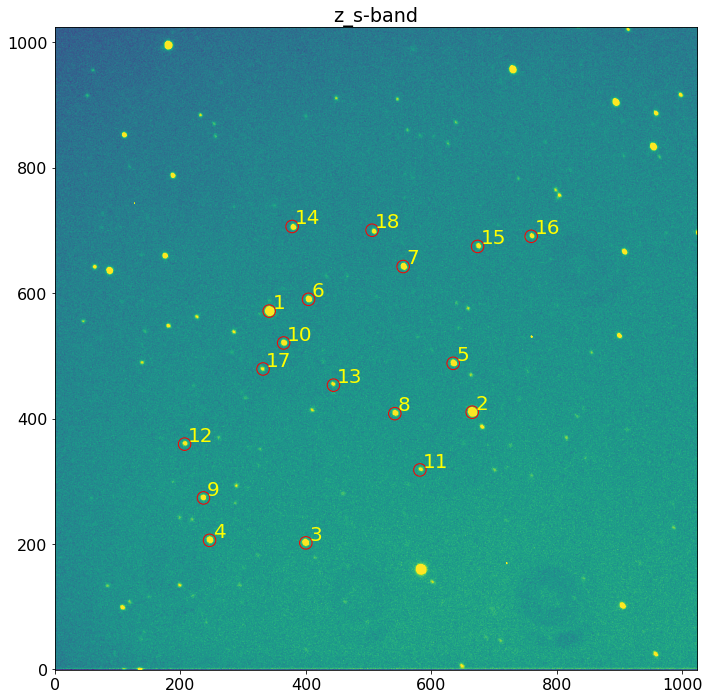

In [20]:
plt.rcParams["font.size"] = 16

## Showing reference image

target_dir = f"{date}/{target}"
ref_list_file = f"{target_dir}/list/ref.lst"
with open(ref_list_file) as f:
    refframe = f.readline()

refframe = refframe.replace('\n','')
print('reference frame:', refframe)

ref_obj_file = f"{target_dir}/objects/{refframe}.objects"
refxy = np.genfromtxt(ref_obj_file, delimiter=13, usecols=(1,2))


ref_fits = f"{target_dir}/reference/ref-{refframe}.fits"
hdulist = fits.open(ref_fits)
data = hdulist[0].data
header = hdulist[0].header


fig = plt.figure(figsize=(10,10), tight_layout=True)
ax = plt.subplot(1,1,1)

norm = ImageNormalize(data, interval=ZScaleInterval())
ax.imshow(data, origin='lower', norm=norm)
ax.set_title(f"{header['FILTER']}-band")

rad=10
for i in range(len(refxy)):
    circ = plt.Circle(refxy[i], rad, color='red', fill=False)
    ax.add_patch(circ)
    ax.text(refxy[i][0]+rad/2., refxy[i][1]+rad/2., str(i+1), fontsize=20, color='yellow')

In [21]:
from urllib.request import urlopen
import json

target_name = "TOI-5956"
url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name}&json"
response = urlopen(url)
data_json = json.loads(response.read())
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(283.317266515486, 59.8176573099652)

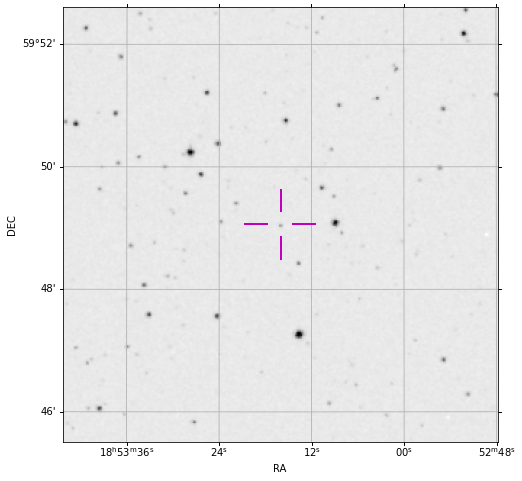

In [22]:
%matplotlib inline
import matplotlib.pyplot as pl
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_finder_image

fov_rad = 7.1*u.arcmin
obj_coord = SkyCoord(ra=ra, dec=dec, unit=(u.deg,u.deg))

#create figure
fig = pl.figure(figsize=(8,8))
#plot fov
ax, hdu = plot_finder_image(obj_coord, fov_radius=fov_rad, survey='DSS2 Red', reticle=True)

In [23]:
#===========
rad_arcsec = 150  #radius of the cropped/ zoom to target

#visualize a sample minimum and maximum phot radius
r1, r2 = 10, 30  # pix
#===========

ref file uploaded to https://nova.astrometry.net/uploaded and wcs file downloaded

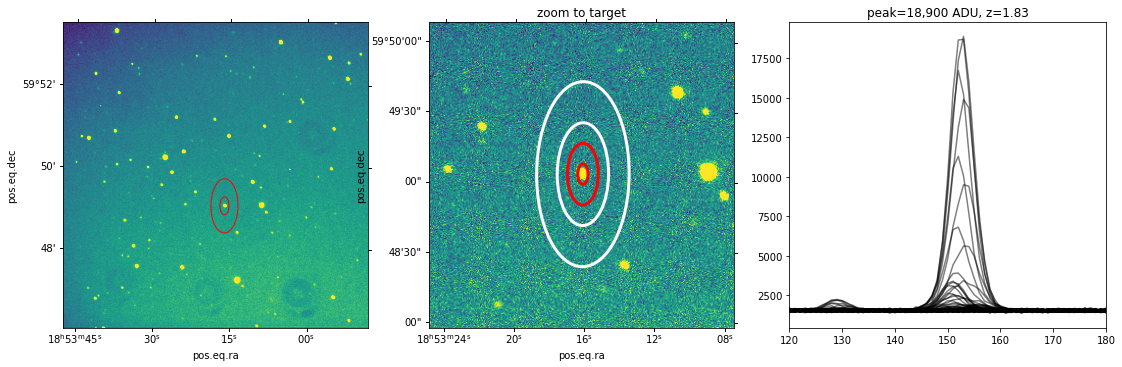

In [24]:
from astropy.wcs import WCS
from matplotlib.patches import Circle

loc = f"/raid_ut3/home/muscat/reduction_afphot/muscat2/{date}/TOI05956.01/reference/ref-MCT23_2304180502.fits"
d = fits.getdata(loc)
h = fits.getheader(loc)
wcs = WCS("/raid_ut3/home/muscat/reduction/muscat2/TOI05956.01/ref-MCT23_2304180502.wcs")
coords = wcs.all_world2pix(np.c_[ra,dec], 0)
xpix, ypix = int(coords[0][0]), int(coords[0][1])

# pixscale = h['PIXSCALE']
pixscale = 0.44#*u.arcsec/u.pixel
dx = dy = round(rad_arcsec)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131, projection=wcs)
ax.imshow(d, norm=ImageNormalize(d, interval=ZScaleInterval(contrast=0.5)), origin="lower")


#show sky annulus positon around target
sky_sep = 50    
sky_wid = 40
for r in [r2,sky_sep+sky_wid]:
    c = Circle((ra, dec), r*pixscale/3600, edgecolor='r', facecolor='none', lw=1,
                  transform=ax.get_transform('fk5'))
    ax.add_patch(c)

dcrop = d[ypix-dy:ypix+dy,xpix-dx:xpix+dx]
wcscrop = wcs[ypix-dy:ypix+dy,xpix-dx:xpix+dx]

ax = fig.add_subplot(132, projection=wcscrop)
ax.imshow(dcrop, norm=ImageNormalize(dcrop, interval=ZScaleInterval(contrast=0.5)))
#aperture min & max
for r in [r1,r2]:
    c = Circle((ra, dec), r*pixscale/3600, edgecolor='r', facecolor='none', lw=3,
                  transform=ax.get_transform('fk5'))
    ax.add_patch(c)
#sky
for r in [sky_sep,sky_sep+sky_wid]:
    c = Circle((ra, dec), r*pixscale/3600, edgecolor='w', facecolor='none', lw=3,
                  transform=ax.get_transform('fk5'))
    ax.add_patch(c)
ax.set_title("zoom to target")

ax = fig.add_subplot(133)
half = dcrop.shape[0]//2
# ax.plot(dcrop[half,:], 'r', lw=3, zorder=10)
ax.plot(dcrop, 'k', alpha=0.5)
ax.set_xlim(half-r2, half+r2)

idx = np.unravel_index(dcrop.argmax(), dcrop.shape)
peak = round(dcrop[idx])
ax.set_title(f"peak={peak:,} ADU, z={h['AIRMASS']:.2f}")
fig.tight_layout()

## Set-up apphot script parameters

In [25]:
# Change the following values
#========
tID = 8     # Target ID
nstars= 10 # number of stars (from the brightest star) to be measured
rad1 = 6   # mininmum aperture radius in pixel
rad2 = 16   # maximum aperture radius in pixel
drad = 2    # step size of aperture radius in pixel
method = 'mapping'  # method to calculate aperture centroids (mapping or centroid)
#========

if method=='mapping':
    script = 'scripts/auto_apphot_mapping.pl'  
elif method=='centroid':
    script = 'scripts/auto_apphot_centroid.pl'

## list apphot arguments

In [26]:
ccds = [0, 1, 2, 3]

def run_apphot(arg):
    # Run the script with the given argument
    command = f"perl {script} {arg}"
    exit_status = os.system(command)
        
    # Check the exit status
    if exit_status == 0:
        print(f"{arg} done.\n")
    else:
        print(f"There was an error running the {script} {arg}\n")

# Create a list of arguments to pass to the script
apphot_args = []
for ccd in ccds:
    for rad in np.arange(rad1,rad2+drad,drad):
        arg = f"{date} {target} {ccd} {nstars} {rad} {rad} {drad}"
        apphot_args.append(arg)
len(apphot_args)

24

## Run apphot all bands in parallel

In [27]:
%%time

from itertools import combinations
from multiprocessing import Pool

# Create a pool of worker processes
os.chdir(inst_dir)

#=============
#the number of concurrent photometry run for a given ccd and aperture radius
njobs = 10
#=============

print(f'>> Performing aperture photometry...\n')
with Pool(njobs) as p:
    # Apply the run_script function to each element in the args_list in parallel
    p.map(run_apphot, apphot_args)

>> Performing aperture photometry...

230418 TOI05956.01 1 10 6 6 2 done.

230418 TOI05956.01 1 10 8 8 2 done.

230418 TOI05956.01 1 10 10 10 2 done.

230418 TOI05956.01 1 10 12 12 2 done.

230418 TOI05956.01 1 10 14 14 2 done.

230418 TOI05956.01 2 10 6 6 2 done.

230418 TOI05956.01 1 10 16 16 2 done.

230418 TOI05956.01 2 10 8 8 2 done.

230418 TOI05956.01 2 10 10 10 2 done.

230418 TOI05956.01 2 10 12 12 2 done.

230418 TOI05956.01 2 10 14 14 2 done.

230418 TOI05956.01 2 10 16 16 2 done.

230418 TOI05956.01 0 10 6 6 2 done.

230418 TOI05956.01 0 10 8 8 2 done.

230418 TOI05956.01 0 10 10 10 2 done.

230418 TOI05956.01 0 10 12 12 2 done.

230418 TOI05956.01 0 10 14 14 2 done.

230418 TOI05956.01 0 10 16 16 2 done.

230418 TOI05956.01 3 10 6 6 2 done.

230418 TOI05956.01 3 10 8 8 2 done.

230418 TOI05956.01 3 10 10 10 2 done.

230418 TOI05956.01 3 10 12 12 2 done.

230418 TOI05956.01 3 10 14 14 2 done.

230418 TOI05956.01 3 10 16 16 2 done.

CPU times: user 254 ms, sys: 92.4 ms, tota

## get all possible combinations of cIDs

In [28]:
from itertools import combinations

#get all cID from 1 to nstars excluding tID
selected_cIDs = [str(i) for i in range(1, nstars+1) if i!=tID]
#or specify each cID below
# selected_cIDs = ['2','3','5','6','7', '8','9','10']
assert str(tID) not in selected_cIDs

cIDs = []
for i in range(len(selected_cIDs)):
    cs = list(combinations(selected_cIDs,i+1))
    flatlist=[' '.join(j) for j in cs]
#     print(flatlist)
    cIDs.append(flatlist)
cIDs = [item for sublist in cIDs for item in sublist]
len(cIDs)

511

## set-up mklc script and arguments

In [29]:
def run_mklc(arg):
    # Run the script with the given argument
    command = f"scripts/auto_mklc.pl {arg}"
    exit_status = os.system(command)
    
    # Check the exit status
    if exit_status == 0:
        print(f"{command} done.")
    else:
        print(f"There was an error running {command}")
    
mklc_args = [f"-date {date} -obj {target} -ap_type {method} -r1 {rad1} -r2 {rad2} -dr {drad} -tid {tID} -cids {cID}" for cID in cIDs]
#mklc commands
len(mklc_args)

511

## run mklc in parallel

In [30]:
njobs = 20

with Pool(njobs) as p:
    # Apply the run_script function to each element in the args_list in parallel
    p.map(run_mklc, mklc_args)

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 3 9 done.scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 5 6 done.

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 5 6 done.scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 7 done.

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 7 9 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 6 7 10 done.scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 5 6 done.

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 7 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 5 6 7 don

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 3 6 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 6 7 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 3 4 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 5 6 7 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 4 5 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 6 7 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 3 4 6 7 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 3 5 6 9 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -d

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 3 5 6 9 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 4 5 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 3 6 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 3 4 5 7 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 4 5 7 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 3 5 6 7 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 3 4 6 7 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 3 5 6 9 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type map

scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 3 4 6 7 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 3 4 5 7 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 3 5 6 7 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 4 5 7 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 2 3 4 6 7 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 3 4 6 7 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 2 3 4 5 7 9 10 done.
scripts/auto_mklc.pl -date 230418 -obj TOI05956.01 -ap_type mapping -r1 6 -r2 16 -dr 2 -tid 8 -cids 1 3 4 5 9 10 done.
scripts/auto_mklc.pl -date 230418 

In [31]:
#create directory where to put csv files based on apphot method
!mkdir $date/$target/$method
!mv $date/$target/*.csv $date/$target/$method/

In [32]:
#show csv files within "method" directory
!ls $date/$target/$method

lcf_muscat2_g_TOI05956.01_230418_t8_c10_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c110_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c1210_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c12310_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c123410_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c1234510_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c12345610_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c123456710_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c1234567910_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c12345679_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c1234567_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c123456910_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c1234569_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c123456_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c12345710_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c123457910_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c1234579_r6-16.csv
lcf_muscat2_g_TOI05956.01_230418_t8_c123457_r6-16.csv
lcf_muscat2_g_T